In [12]:
import gmsh
import numpy as np

In [13]:
E=30e6
nu=0.3
t=1

In [14]:
gmsh.initialize()
gmsh.model.add('ej2guia3')

lc = 1
L = 20
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(L, 0, 0, lc) 
p3 = gmsh.model.geo.addPoint(L, L/2, 0, lc) 
p4 = gmsh.model.geo.addPoint(0, L/2, 0, lc) 
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

S1 = gmsh.model.geo.addPlaneSurface([C1])

gmsh.model.geo.synchronize()
#gmsh.fltk.run()

gmsh.model.mesh.generate(2)

gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.write('ej2guia3.msh')

In [15]:
Empotrado = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')
Traccionado = gmsh.model.addPhysicalGroup(1, [l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

gmsh.model.mesh.generate(2)

In [16]:
NodeInfo = gmsh.model.mesh.get_nodes()

NumeroNodos = NodeInfo[0].shape[0]

MN = NodeInfo[1].reshape(NumeroNodos , 3)
#print(MN)

ElementInfo = gmsh.model.mesh.get_elements()
ETYPES = ElementInfo[0]


ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

MC = ELEMENTS.reshape([ETAGS.shape[0],3])

In [17]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
#print(entityTraccionada)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])
#print(Tgroup, Ttraccionada, Ltraccionada)

In [18]:
Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)
Longitudes = np.abs( MN[Ltraccionada[:,0]-1,1] - MN[Ltraccionada[:,1]-1,1] )  #De la parte traccionada de la chapa calcula la altura
#print(MN)
#print(Ltraccionada)
#print( MN[Ltraccionada[:,0]-1,1],MN[Ltraccionada[:,1]-1,1])

In [19]:

Fuerzas = np.zeros((2*NumeroNodos,1))
tension = 5000 #Pa
for l, linea in enumerate(Ltraccionada):
    #print(linea)
    Flocal = np.array([[1],[1]])*tension*t*Longitudes[l]
    n1 = linea[0]
    n2 = linea[1]
    #print(Flocal)
    Fuerzas[ np.array([2*(n1-1), 2*(n2-1)], dtype=int)] += Flocal
#print(Fuerzas)

In [20]:
NodosEmpotrados = gmsh.model.mesh.get_nodes_for_physical_group(1,Empotrado)
#print(NodosEmpotrados[0]-1)
s = []
r = np.arange(2*NumeroNodos)
for n, nodo in enumerate(NodosEmpotrados[0]-1):
    s.append(
        np.linspace(2*nodo, 2*nodo +1, 2)
    )
s = np.array(s).astype(int)

r = np.delete( r, s )
S=[]
for i in range(len(s)):
    for j in range(2):
        S.append(s[i,j])
s=S

#print(r,s)
#print(MN)
#print(Fuerzas)
#print()
#print(Fuerzas[r])
#print(Fuerzas[s])

In [21]:

D=np.dot((E/(1-nu**2)),np.array([[1,nu,0],[nu,1,0],[0,0,.5*(1-nu)]]))

A=[]
beta=np.zeros((3,3))
gamma=np.zeros((3,3))
Matriz_area = np.zeros((3,3))
Matriz_area[:,0] = 1
kglobal=np.zeros((2*len(MN),2*len(MN)))


for i in range(len(MC)):
    ii,mm,jj = MC[i]-1
 #   print(ii,mm,jj)
    kred=np.zeros((8,8))
    B=np.zeros((3,6))
    I=MC[i,:]-1
    X=MN[I,0]
    Y=MN[I,1]
    
    Matriz_area[:,1] = X
    Matriz_area[:,2] = Y

    A=(np.linalg.det(Matriz_area)/2)
    beta[0] = Y[1] - Y[2]
    beta[1] = Y[2] - Y[0]
    beta[2] = Y[0] - Y[1]
    gamma[0] = X[2] - X[1]
    gamma[1] = X[0] - X[2]
    gamma[2] = X[1] - X[0]
    for j in range(3):
        B[0,2*j] = beta[j,0]
        B[1,2*j + 1] = gamma[j,0]
        B[2,2*j] = gamma[j,0]
        B[2,2*j + 1] = beta[j,0]
    B=B/(2*A)
    #print(B)
    
    kloc=t*np.absolute(A)*np.dot(np.transpose(B),np.dot(D,B))
    A_G = np.array([int(ii*2),int(ii*2+1),int(mm*2),int(mm*2+1),int(jj*2),int(jj*2+1)]) 
#    print(A_G)
    kglobal[np.ix_(A_G,A_G)] += kloc
#print(kglobal*0.91/375000)
#print(r,s)  #r son los fuerza dada, s los fuerza incognita (empotrados)
#print()
#print(Fuerzas[s])
#print(s)
#print(r)
#print(np.dot(kglobal[np.ix_(s,s)],Fuerzas[s])*0.91/375000)
#print(np.dot(kglobal[np.ix_(r,r)],Fuerzas[r])*0.91/375000)
#print(np.dot(kglobal[np.ix_(s,s)],Fuerzas[s])*0.91/375000)

In [22]:
kglobal_r=kglobal[np.ix_(r,r)]
desp=(np.dot(np.linalg.inv(kglobal_r),Fuerzas[r]))
Desplazamientos=np.zeros((2*len(MN),1))
a=0
#print(r)
for i in r:
    Desplazamientos[i]+=desp[a]
    a+=1
R=np.dot(kglobal[np.ix_(r,r)],Fuerzas[r])
Resultantes=np.zeros((2*len(MN),1))
a=0
for i in s:
    Resultantes[i]+=R[a]
    a+=1
#print(Resultantes)

In [23]:
#Desplazamientos*1e6

(-1.0, 40.000000000030454)

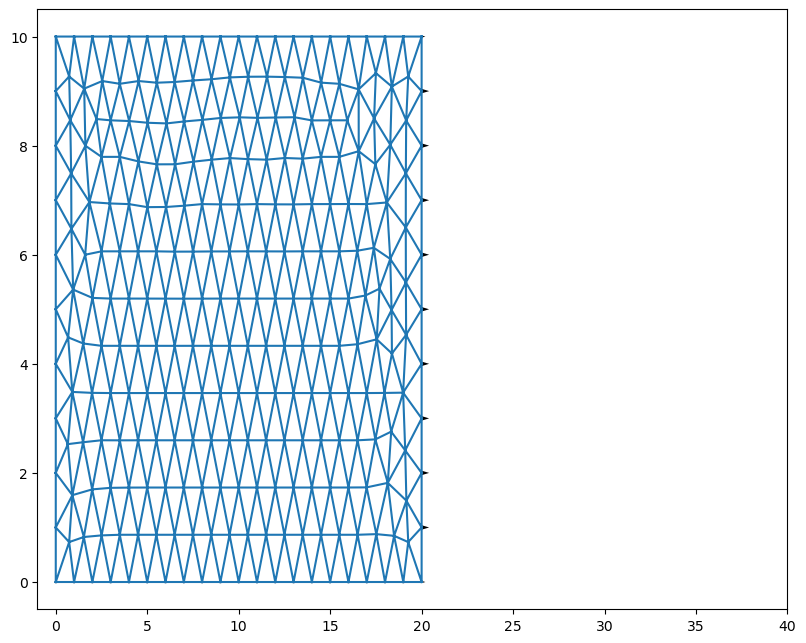

In [24]:
import matplotlib.pyplot as plt
from matplotlib import quiver

plt.style.use('default')
plt.rc('figure',figsize=(15,10))

Fx = Fuerzas[2*np.arange(NumeroNodos)]
Fy = Fuerzas[2*np.arange(NumeroNodos)+1]

#plt.plot(MN[:,0],MN[:,1],'ok')

#plt.plot(MNE[:,0], MNE[:,1], label='Empotrados', lw = 5)
#plt.plot(MNT[:,0], MNT[:,1], label='Traccionados', lw = 5)
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
#ax.plot(MN[:,0],MN[:,1],'o')
ax.quiver( MN[:,0], MN[:,1], Fx/100, Fy/100, linewidth=5, units='width', scale=10000)
ax.set_xlim(-1, L+(Fx/500).max())